In [14]:
import torch
import torch.nn.functional as F
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv('physics_equations.csv')

functions = []
num_vars_per_func = []

for _, row in df.iterrows():
    formula = row['Formula']
    num_vars = row['# variables']
    function_details = {
        'formula': formula,
        'variables': []
    }
    
    for i in range(1, 11):  
        v_name = row.get(f'v{i}_name', None)
        v_low = row.get(f'v{i}_low', None)
        v_high = row.get(f'v{i}_high', None)
        
        if pd.notna(v_name):
            function_details['variables'].append({
                'name': v_name,
                'low': v_low,
                'high': v_high
            })
    
    functions.append(function_details)
    num_vars_per_func.append(num_vars)

'''for i, func in enumerate(functions):
    print(f"Function {i+1}:")
    print(f"  Formula: {func['formula']}")
    print(f"  Number of Variables: {num_vars_per_func[i]}")
    print("  Variables:")
    for var in func['variables']:
        print(f"    - Name: {var['name']}, Range: ({var['low']}, {var['high']})")
    print()'''

'for i, func in enumerate(functions):\n    print(f"Function {i+1}:")\n    print(f"  Formula: {func[\'formula\']}")\n    print(f"  Number of Variables: {num_vars_per_func[i]}")\n    print("  Variables:")\n    for var in func[\'variables\']:\n        print(f"    - Name: {var[\'name\']}, Range: ({var[\'low\']}, {var[\'high\']})")\n    print()'

In [4]:
def generate_function(function, sample_size, x, max_vars, device):
    sympy_symbols = []
    param_tensors = []
    
    for var in function["variables"]:
        sym = sp.symbols(var["name"])
        sympy_symbols.append(sym)
        min_val, max_val = var["low"], var["high"]
        param = (max_val - min_val) * torch.rand(sample_size, 1, device=device) + min_val
        param_tensors.append(param)
    sympy_symbols.append(sp.symbols('x'))
    params = torch.cat(param_tensors, dim=1)
    padded_params = F.pad(params, pad=(0, max_vars - params.size(1)))
    padded_params = padded_params.expand(sample_size, max_vars)
    formula = sp.sympify(function["formula"])
    eval_func = sp.lambdify(sympy_symbols, formula, modules="numpy")
        
    results = []
    for xi in x:
        input_values = torch.cat([params, xi.expand(sample_size, 1)], dim=1)
        results.append(eval_func(*input_values.T))
    results = torch.stack(results, dim=1)
    
    return [results, formula, sympy_symbols, padded_params]

In [5]:
sample_size = 10000
sequence_length = 100
num_funcs = 10
max_vars = 5

x_values = torch.linspace(-1, 1, sequence_length).to(device)
hold = []
for f in range(num_funcs): #functions[0:10]:
    try:
        results = generate_function(functions[f], sample_size, x_values, max_vars, device)
        results.append(f)
        funcs = torch.zeros(num_funcs)
        funcs[f] = 1
        results.append(funcs)
        hold.append(results)        
    except Exception as e:
        print(f"Error processing function {f}: {e}")

In [6]:
y_values = torch.stack([l[0] for l in hold])
formulas = [l[1] for l in hold]
symbols = [l[2] for l in hold]
param_values = [l[3] for l in hold]
num_params = torch.tensor([len(l[2])-1 for l in hold])
function_labels = [l[4] for l in hold]
target_funcs = [l[5] for l in hold]

In [7]:
target_funcs = torch.stack(target_funcs)
target_funcs = target_funcs.repeat_interleave(sample_size, dim=0)
target_funcs.shape

torch.Size([100000, 10])

In [8]:
full_params = torch.zeros(num_funcs, sample_size, num_funcs*max_vars)
for f in range(num_funcs):
    for i in range(sample_size):
        full_params[f, i, f*max_vars:f*max_vars+max_vars] = param_values[f][i]
full_params.shape

torch.Size([10, 10000, 50])

In [9]:
param_values = torch.stack(param_values)
full_params = full_params.flatten(0, 1)

In [11]:
torch.save({
    'x_values': x_values,
    'y_values': y_values,
    'target_funcs': target_funcs
}, 'hold_data1.pth')

torch.save({
    'formulas': formulas,
    'symbols': symbols,
}, 'hold_data2.pth')

torch.save({
    'param_values': param_values,
    'full_params': full_params,
    'num_params': num_params
}, 'hold_data3.pth')

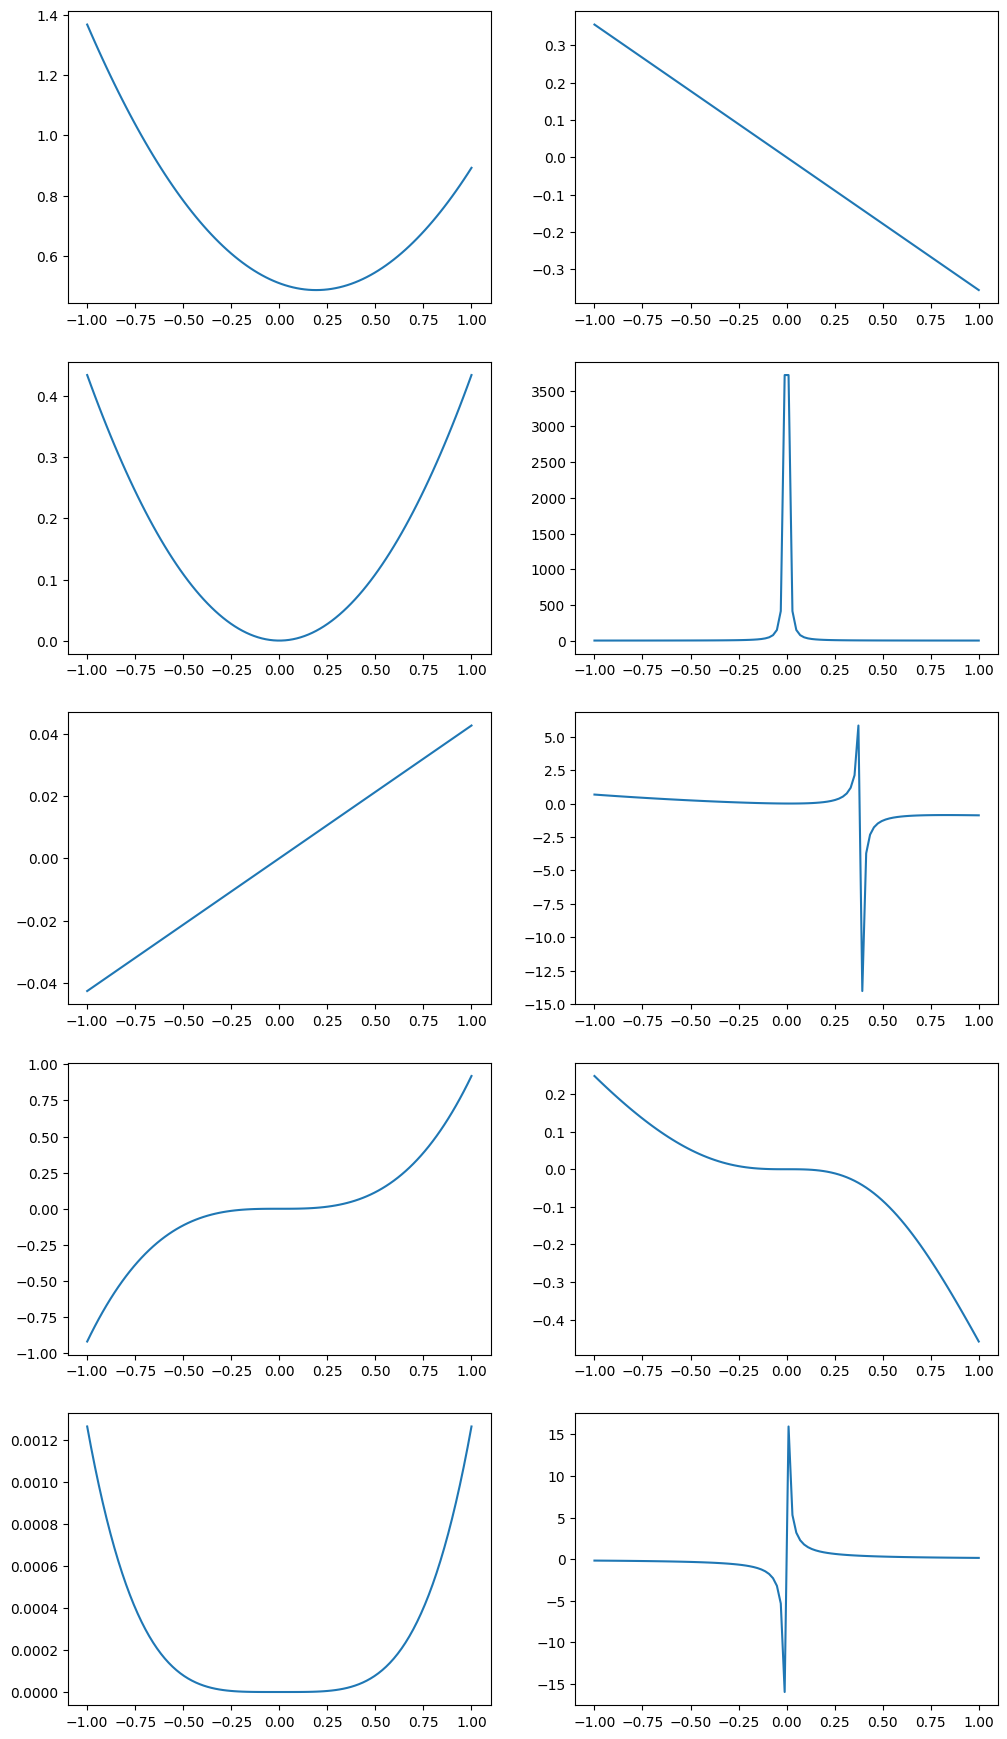

In [15]:
fig, axes = plt.subplots((num_funcs+1)//2, 2, figsize=(12, 4*(num_funcs+1)//2))
axes = axes.flatten()

for f in range(num_funcs):
    axes[f].plot(x_values.cpu().numpy(), y_values[f, 0].cpu().numpy())